## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imageio
import os
from glob import glob
import random
import time
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torchvision
from torchvision import transforms as T
from torchvision.transforms import functional as TF


from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Data

In [2]:
train_img_path = "./SUIM/train_val/images"
train_mask_path = "./SUIM/train_val/masks"

test_img_path = "./SUIM/TEST/images"
test_mask_path = "./SUIM/TEST/masks"
image_paths = sorted(glob(os.path.join(train_img_path, '*')))
mask_paths = sorted(glob(os.path.join(train_mask_path, '*')))

### Plotting random images from dataset with their respective masks andalso add the mask on the original image

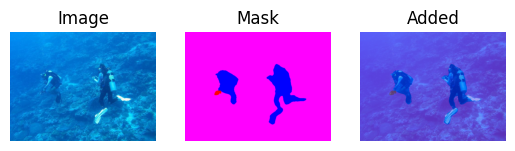

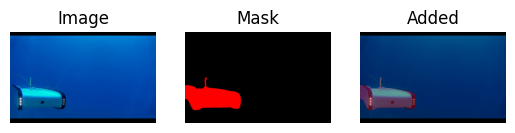

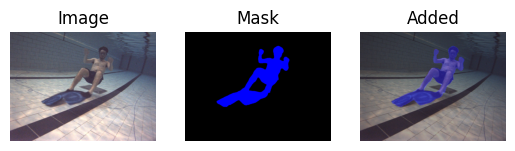

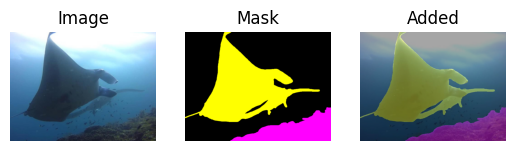

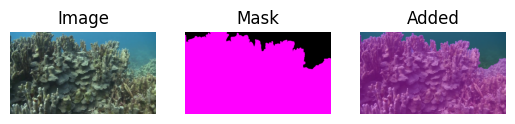

In [3]:
for i in np.random.randint(0,300,size=5):
    img = imageio.v2.imread(image_paths[i])
    mask = imageio.v2.imread(mask_paths[i])
    added_image = (img*0.65+ mask*0.35).astype(int)
    plt.figure()
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('Image')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(mask)
    plt.title('Mask')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(added_image)
    plt.title('Added')
    plt.axis('off')
    plt.show()

### Some Utility Functions

In [4]:
num_classes = 8
h_crop = 160
w_crop = 160
# temp list for one hot conversion and viceversa
binary_encoded = [[0, 0, 0],[0, 0, 1], [0, 1, 0], [0, 1, 1], [1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]]
one_hot_encoded = [[1 if j == i else 0 for j in range(8)] for i in range(8)]
def bin2ohe(mask, num_class, binary_encoded, one_hot_encoded):
    mask = mask.permute(1,2,0)
    mask = mask.numpy()
    mask = mask.astype(np.int64)
    h,w = mask.shape[:-1]
    layout = np.zeros((h, w, num_class), dtype=np.int64)
    for i, label in enumerate(binary_encoded):
        layout[np.all(mask == label, axis = -1)] = one_hot_encoded[i]
    layout = layout.astype(np.float64)
    layout = torch.from_numpy(layout)
    layout = layout.permute(2,0,1)
    return layout

def ohe2bin(mask, one_hot_encoded, binary_encoded):
    mask = mask.permute(1,2,0)
    mask = mask.numpy()
    h,w = mask.shape[:-1]
    layout = np.zeros((h,w,3), dtype=np.int64)
    for i, label in enumerate(one_hot_encoded):
        layout[np.all(mask == label, axis = -1)] = binary_encoded[i]

    layout = layout.astype(np.float64)
    layout = torch.from_numpy(layout)
    layout = layout.permute(2,0,1)
    return layout

def argmax_predict(pred):
    pred = F.softmax(pred, dim=1)
    pred = pred.numpy()
    # thresholding
    for img in range(pred.shape[0]):
        tmp_pred = pred[img]
        pred_arg = np.argmax(tmp_pred, axis=0)
        layout = np.zeros((h_crop, w_crop, num_classes))

        for i in range(0,num_classes):
            layout[pred_arg == i] = one_hot_encoded[i]
        layout = np.transpose(layout, (2,0,1))
        pred[img] = layout
    return pred

In [5]:
def plot_img_label(img, label):
    # plot
    img = img.permute(1, 2, 0)

    # ohe to rgb
    test_mask_rgb = ohe2bin(label, one_hot_encoded, binary_encoded)
    test_mask_rgb = test_mask_rgb.permute(1, 2, 0)

    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(test_mask_rgb * 1.0)
    plt.axis('off')
    plt.show()

    plt.figure(figsize=(10,6))
    for i in range(num_classes):
        plt.subplot(2,4,i + 1)
        plt.axis('off')
        plt.title(f'class {i:03b}')
        plt.imshow(label[i,:,:], cmap='gray')
    plt.show()

def plot_img_label_pred(img, label, pred):
    # pred
    pred = pred.permute(1,2,0)
    pred = pred.numpy()

    pred_arg = np.argmax(pred, axis=2)
    layout = np.zeros((h_crop, w_crop, 3))

    for i in range(0,num_classes):
        layout[pred_arg == i] = binary_encoded[i]

    # plot
    img = img.permute(1, 2, 0)

    # ohe to rgb
    test_mask_rgb = ohe2bin(label, one_hot_encoded, binary_encoded)
    test_mask_rgb = test_mask_rgb.permute(1, 2, 0)

    plt.figure()
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(test_mask_rgb * 1.0)
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(layout * 1.0)
    plt.axis('off')
    plt.show()

    plt.figure(figsize=(10,6))
    for i in range(num_classes):
        plt.subplot(2,4,i + 1)
        plt.axis('off')
        plt.title(f'class {i:03b}')
        plt.imshow(label[i,:,:], cmap='gray')
    plt.show()

    plt.figure(figsize=(10,6))
    for i in range(num_classes):
        plt.subplot(2,4,i + 1)
        plt.axis('off')
        plt.title(f'class {i:03b}')
        plt.imshow(pred[:,:,i], cmap='gray')
    plt.show()

### Define Dataloader

In [6]:
# Dataset Hyperparameter
h_crop = 160
w_crop = 160
rot_angle = 30 # Rotation angle generated randomly between [-rot_angle, rot_angle]
rot_flag = True
shuffle_flag = True
shear_angle = 30
shear_flag = True
pixel_translate = 50
translate_flag = True
vflip_flag = True
hflip_flag = True
class SuimDataset(Dataset):
    def __init__(self, imgs_dir, masks_dir, transform_flag=True, hflip=False, vflip=False, rotate=False, shear=False, translate=False):
        self.image_paths = imgs_dir
        self.mask_paths = masks_dir
        self.transform_flag = transform_flag
        self.hflip = hflip
        self.vflip = vflip
        self.rotate = rotate
        self.shear = shear
        self.translate = translate

    def transform(self, image, mask):
        # random angle interval
        rot_interval = [-rot_angle, rot_angle]
        shear_interval = [-shear_angle, shear_angle]
        translate_interval = [-pixel_translate, pixel_translate]

        ran_angle = 0
        ran_translate_x, ran_translate_y = 0, 0
        ran_shear_angle = 0


        image = TF.resize(image, [h_crop,w_crop], interpolation=T.InterpolationMode.NEAREST)
        mask = TF.resize(mask, [h_crop,w_crop], interpolation=T.InterpolationMode.NEAREST)

        # Generate 8 mask for each class from the bitmap mask
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        mask = torch.round(mask)

        if self.transform_flag:
            image = TF.pad(image, padding=h_crop//2, padding_mode="reflect")
            mask = TF.pad(mask, padding=h_crop//2, padding_mode="reflect")
            # horizontal flipping
            if self.hflip:
                image = TF.hflip(image)
                mask = TF.hflip(mask)
            # vertical flipping
            if self.vflip:
                image = TF.vflip(image)
                mask = TF.vflip(mask)
            if self.rotate:
                ran_angle = random.uniform(rot_interval[0], rot_interval[1])
            if self.shear:
                ran_shear_angle = random.uniform(shear_interval[0], shear_interval[1])
            if self.translate:
                ran_translate_x = random.uniform(translate_interval[0], translate_interval[1])
                ran_translate_y = random.uniform(translate_interval[0], translate_interval[1])

            # Apply affine transform with rotation, shear and translation
            image = TF.affine(image, angle=ran_angle, translate=(ran_translate_x,ran_translate_y), scale=1, shear=ran_shear_angle, interpolation=T.InterpolationMode.NEAREST)
            mask = TF.affine(mask, angle=ran_angle, translate=(ran_translate_x,ran_translate_y), scale=1, shear=ran_shear_angle, interpolation=T.InterpolationMode.NEAREST)

            cropper = T.CenterCrop(size=[h_crop,w_crop])

            image = cropper(image)
            mask = cropper(mask)

        # One hot encoding
        layout = bin2ohe(mask, num_classes, binary_encoded, one_hot_encoded)
        return image, layout

    def __getitem__(self, index):

        image = Image.open(self.image_paths[index])
        mask = Image.open(self.mask_paths[index])

        image, mask = self.transform(image, mask)
        return image, mask

    def __len__(self):
        return len(self.image_paths)

### Split data to train and validation sets

In [7]:
# Split in train e val
train_split_img, val_split_img, train_split_mask, val_split_mask = train_test_split(image_paths, mask_paths, test_size=0.1)

dataset1 = SuimDataset(train_split_img, train_split_mask, transform_flag = False)
dataset2 = SuimDataset(train_split_img, train_split_mask, transform_flag = True, hflip=hflip_flag, rotate=rot_flag, shear=shear_flag, translate=translate_flag)
dataset3 = SuimDataset(train_split_img, train_split_mask, transform_flag = True, vflip=vflip_flag, rotate=rot_flag, shear=shear_flag, translate=translate_flag)
dataset4 = SuimDataset(train_split_img, train_split_mask, transform_flag = True, hflip=hflip_flag, vflip=vflip_flag, rotate=rot_flag, shear=shear_flag, translate=translate_flag)

dataset = torch.utils.data.ConcatDataset([dataset1, dataset2, dataset3, dataset4])

dataset_val = SuimDataset(val_split_img, val_split_mask, transform_flag = False)

batch_size = 16
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle_flag)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=shuffle_flag)

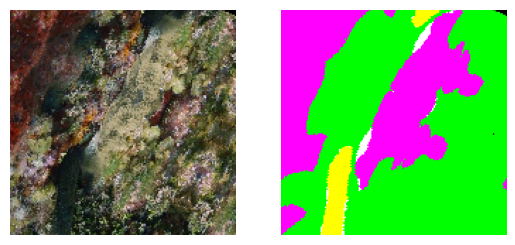

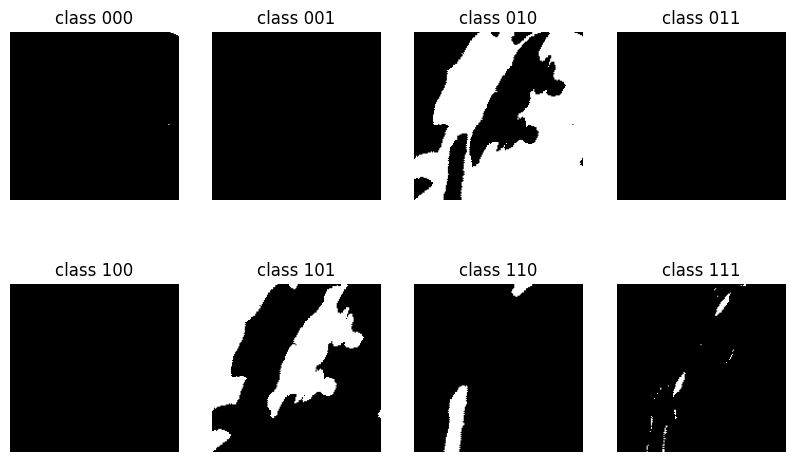

In [8]:
idx = np.random.randint(0, len(image_paths))

image = Image.open(image_paths[idx])
mask = Image.open(mask_paths[idx])
img,mask = dataset4.transform(image,mask)
plot_img_label(img, mask)

## Define the UNet

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class PyramidPoolingModule(nn.Module):
    def __init__(self, in_channels, pool_sizes=(1, 2, 3, 6)):
        super(PyramidPoolingModule, self).__init__()

        self.pooling_modules = nn.ModuleList()
        for pool_size in pool_sizes:
            self.pooling_modules.append(nn.AdaptiveAvgPool2d(pool_size))

        self.conv = nn.Conv2d(in_channels * (len(pool_sizes) + 1), in_channels, kernel_size=1)

    def forward(self, x):
        pool_outputs = [x]
        for module in self.pooling_modules:
            pool_outputs.append(F.interpolate(module(x), size=x.size()[2:], mode='bilinear', align_corners=False))

        x = torch.cat(pool_outputs, dim=1)
        x = self.conv(x)
        return x

class PSPNet(nn.Module):
    def __init__(self, num_classes):
        super(PSPNet, self).__init__()

        # MobileNetV2 backbone
        self.backbone = models.mobilenet_v2(pretrained=True)
        self.features = self.backbone.features

        # Pyramid Pooling Module
        in_channels = 1280  # MobileNetV2 output channels
        self.ppm = PyramidPoolingModule(in_channels)

        # Final classification layer
        self.final_conv = nn.Conv2d(in_channels, num_classes, kernel_size=1)

    def forward(self, x):
        # Backbone
        x = self.features(x)

        # Pyramid Pooling Module
        x = self.ppm(x)

        # Final classification layer
        x = self.final_conv(x)

        # Upsample to the original input size
        x = F.interpolate(x, size=(x.size()[2] * 32, x.size()[3] * 32), mode='bilinear', align_corners=False)

        return x

# Example usage
num_classes = 8  # Assuming 21 classes for illustration
model = PSPNet(num_classes)
input_tensor = torch.randn((1, 3, 160, 160))  # Example input size
output_tensor = model(input_tensor)
print("Output Shape:", output_tensor.shape)


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\USER/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/1

Output Shape: torch.Size([1, 8, 160, 160])


## Define some metrics like IoU

In [10]:
def IoU(preds, masks):
    preds = torch.round(F.softmax(preds.cpu().detach(), dim=1))
    preds = (preds.view(-1)).numpy()
    masks = (masks.cpu().view(-1)).numpy()
    intersection = np.logical_and(preds, masks)
    union = np.logical_or(preds, masks)
    iou = np.sum(intersection) / np.sum(union)
    return iou

## Train Function

In [11]:
def train_model(model, loss_fn, optimizer, scheduler, num_epochs):
    torch.cuda.empty_cache()
    best_model_wts = copy.deepcopy(model.state_dict())
    since = time.time()
    train_losses = []
    val_losses = [] 
    train_iou = []
    val_iou = []
    best_val_loss = np.inf
    best_val_iou = 0
   
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 15)
        tic = time.time()
        # Sum of the loss for each batch
        running_loss = 0
        # Iou score at epoch
        iou_score = 0
        
        # Training
        model.train()
        for idx, (images, masks) in enumerate(train_loader):
            images = images.to(device)
            masks = masks.to(device)
            
            optimizer.zero_grad()
            # Model prediction
            output = model(images)
            # Loss and gradient calculation
            loss = loss_fn(output, masks)            
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            iou_score += IoU(output, masks)
        print(f'Training: Loss = {running_loss/len(train_loader):.3f} mIoU =  {iou_score/len(train_loader):.3f}')
        # Scheduler
        scheduler.step()
            
        val_running_loss = 0    
        val_iou_score = 0
        # Validation
        for idx, (images, masks) in enumerate(val_loader):
            # Set model to evaluation and load data to GPU
            images = images.to(device)
            masks = masks.to(device)
            model.eval()
            
            output = model(images)
            #Loss and IoU evaluation
            loss = loss_fn(output, masks)            
            
            val_running_loss += loss.item()
            val_iou_score +=  IoU(output, masks)
        print(f'Validation: Loss = {val_running_loss/len(val_loader):.3f} mIoU =  {val_iou_score/len(val_loader):.3f}')
        
        train_losses.append(running_loss/len(train_loader))
        val_losses.append(val_running_loss/len(val_loader))
        val_iou.append(val_iou_score/len(val_loader))
        train_iou.append(iou_score/len(train_loader))

        toc = time.time()
        print(f'Time: {(toc-tic) // 60:.0f}m {(toc-tic) % 60:.0f}s')
        # Saving model with minimum loss on validation set
        if val_iou_score/len(val_loader) > best_val_iou:
            best_val_iou = copy.deepcopy(val_iou_score/len(val_loader))
            best_model_wts = copy.deepcopy(model.state_dict())

    # Epoch end, return history of the loss
    history = {
        'train_losses' : train_losses,
        'val_losses': val_losses,
        'train_iou': train_iou,
        'val_iou':val_iou,
    }
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    torch.save(best_model_wts, 'model_weights_UNet.pth')    
    model.load_state_dict(best_model_wts)
    return model, history

## Main

### Loss Weight

Because of class imbalance we calculate how many times each class happened in train dataset and set the loss weight of each one proportional to inverse of it

In [12]:
class_hap = np.zeros(8)
for i in range(len(dataset1)):
    for cls in range(num_classes):
        class_hap[cls] += np.sum(dataset1[i][1][cls].numpy())
loss_weigths = sum(class_hap)/(10*class_hap)

In [13]:
loss_weigths = np.array([0.6, 3, 3, 1.5, 3.5, 0.6, 1.5, 1])

### Training

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = PSPNet(num_classes).to(device)
# Defining the Loss function and the optimizer
criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(loss_weigths).to(device))
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=2e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
num_epochs = 40
model, history = train_model(model, loss_fn = criterion, optimizer = optimizer,
                       scheduler = exp_lr_scheduler, num_epochs = num_epochs)

Epoch 0/39
---------------
Training: Loss = 1.295 mIoU =  0.330
Validation: Loss = 1.123 mIoU =  0.442
Time: 1m 59s
Epoch 1/39
---------------
Training: Loss = 0.978 mIoU =  0.451
Validation: Loss = 0.938 mIoU =  0.416
Time: 1m 60s
Epoch 2/39
---------------
Training: Loss = 0.888 mIoU =  0.491
Validation: Loss = 0.924 mIoU =  0.513
Time: 1m 59s
Epoch 3/39
---------------
Training: Loss = 0.842 mIoU =  0.513
Validation: Loss = 0.958 mIoU =  0.516
Time: 1m 58s
Epoch 4/39
---------------
Training: Loss = 0.800 mIoU =  0.530
Validation: Loss = 0.858 mIoU =  0.557
Time: 1m 58s
Epoch 5/39
---------------
Training: Loss = 0.763 mIoU =  0.548
Validation: Loss = 0.819 mIoU =  0.468
Time: 2m 0s
Epoch 6/39
---------------
Training: Loss = 0.713 mIoU =  0.573
Validation: Loss = 0.823 mIoU =  0.490
Time: 2m 0s
Epoch 7/39
---------------
Training: Loss = 0.754 mIoU =  0.551
Validation: Loss = 0.906 mIoU =  0.510
Time: 1m 59s
Epoch 8/39
---------------
Training: Loss = 0.729 mIoU =  0.562
Validation

### Plot Loss and mIoU

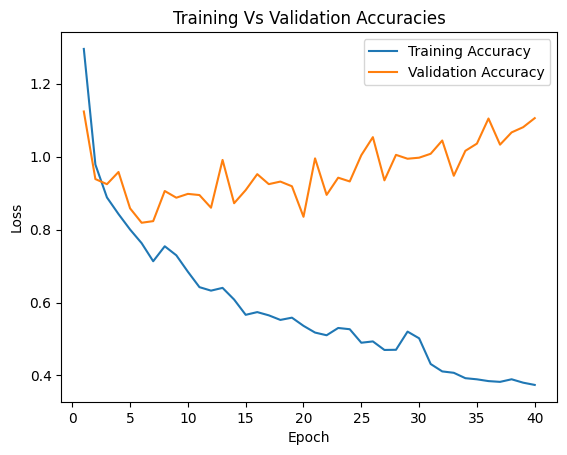

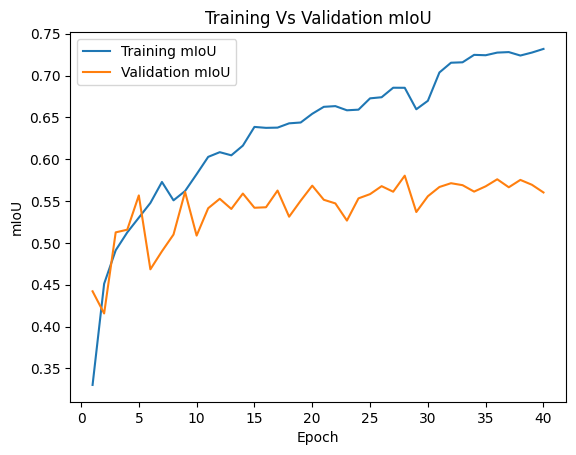

In [15]:
plt.title("Training Vs Validation Accuracies")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(list(range(1, len(history['train_losses'])+1)), history['train_losses'], label="Training Accuracy")
plt.plot(list(range(1, len(history['val_losses'])+1)), history['val_losses'], label="Validation Accuracy")
plt.legend()
plt.show()

plt.title("Training Vs Validation mIoU")
plt.xlabel('Epoch')
plt.ylabel('mIoU')
plt.plot(list(range(1, len(history['train_iou'])+1)), history['train_iou'], label="Training mIoU")
plt.plot(list(range(1, len(history['val_iou'])+1)), history['val_iou'], label="Validation mIoU")
plt.legend()
plt.show()

## Test

In [16]:
class SuimTestDataset(Dataset):
    '''
        Dataloader
    '''
    def __init__(self, imgs_dir, masks_dir):
        self.image_paths = sorted(glob(os.path.join(imgs_dir, '*')))
        self.mask_paths = sorted(glob(os.path.join(masks_dir, '*.bmp')))

    def transform(self, image, mask):
        image = TF.resize(image, [h_crop,w_crop], interpolation=T.InterpolationMode.NEAREST)
        mask = TF.resize(mask, [h_crop,w_crop], interpolation=T.InterpolationMode.NEAREST)

        # Generate 8 mask for each class from the bitmap mask
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)

        # One hot encoding
        layout = bin2ohe(mask, num_classes, binary_encoded, one_hot_encoded)
        return image, layout

    def __getitem__(self, index):

        image = Image.open(self.image_paths[index])
        mask = Image.open(self.mask_paths[index])

        image, mask = self.transform(image, mask)
        return image, mask

    def __len__(self):
        return len(self.image_paths)

In [17]:
test_dataset = SuimTestDataset(test_img_path, test_mask_path)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)
iou_scores = []
for idx,(images, masks) in enumerate(test_loader):
    images = images.to(device)
    masks = masks.to(device)

    model.eval()

    with torch.no_grad():
        pred = model(images)
    iou_score = IoU(pred, masks)
    pred = argmax_predict(pred.cpu())

    iou_scores.append(iou_score)

print(f"Test IoU = {np.mean(iou_scores)}")

Test IoU = 0.6278355759805643


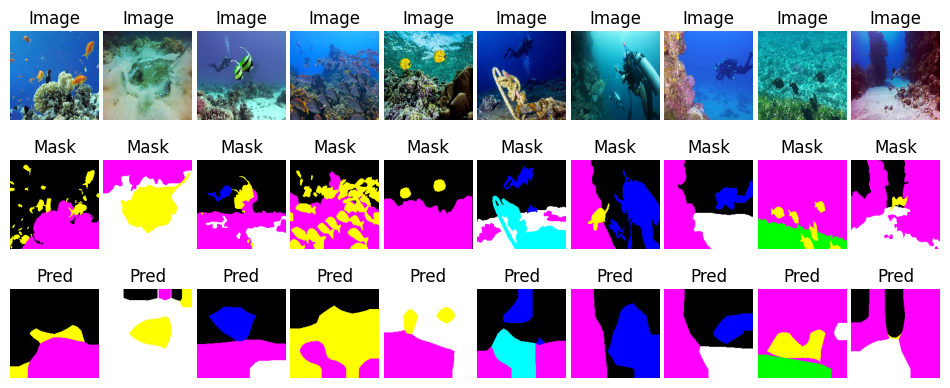

In [18]:
model.eval()
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)
images, masks = next(iter(test_loader))
with torch.no_grad():
    preds = model(images.to(device))
preds = argmax_predict(preds.cpu())
preds = torch.from_numpy(preds)

plt.figure(figsize=(12,5))
for i in range(10):
    plt.subplot(3,10,i+1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.title('Image')
    plt.axis('off')
    mask = ohe2bin(masks[i], one_hot_encoded, binary_encoded)
    mask = mask.permute(1, 2, 0)
    plt.subplot(3,10,i+11)
    plt.imshow(mask)
    plt.title('Mask')
    plt.axis('off')
    pred = ohe2bin(preds[i], one_hot_encoded, binary_encoded)
    plt.subplot(3,10,i+21)
    plt.imshow(pred.permute(1, 2, 0))
    plt.title('Pred')
    plt.axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0.01)
plt.show()